<a href="https://colab.research.google.com/github/mint-aguccim/Machine_Learning_Programming/blob/main/9%EC%A3%BC%EC%B0%A8/%EA%B3%BC%EC%A0%9C2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [3]:
# 1. 데이터 로드
# Volume, Adj Close를 지우라는 요청은 'Close' 컬럼만 선택함으로써 해결됩니다.
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TSLA.csv')

In [4]:
# 예측 대상인 'Close' 컬럼만 선택합니다.
data = df['Close'].values.reshape(-1,1)

In [5]:
# 2. window 정의
# 60일(약 3개월)의 데이터를 보고 다음 날을 예측
window = 60

In [6]:
# 3. [수정] Train / Test 데이터 분리 (스케일링 *전* 원본 데이터 기준)
split_point = int(len(data) * 0.8)
train_data = data[:split_point]
test_data = data[split_point:]

In [7]:
print(f"Original data points: {len(data)}")
print(f"Train data points: {len(train_data)}")
print(f"Test data points: {len(test_data)}")

Original data points: 2956
Train data points: 2364
Test data points: 592


In [8]:
# 4. [수정] 스케일링 (Data Leakage 방지)
scaler = MinMaxScaler()
# 4-1. scaler를 'train_data'에만 fit 합니다.
scaler.fit(train_data)

MinMaxScaler()

In [9]:
# 4-2. fit된 scaler로 train과 test 데이터를 각각 'transform' 합니다.
train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

In [10]:
# 5. 시퀀스 생성을 위한 함수 정의 (window 생성)
def create_sequences(sequence, window):
    X, y = [], []
    for i in range(len(sequence) - window):
        # i부터 i+window 까지 (60개)
        X.append(sequence[i:i+window])
        # i+window (61번째)
        y.append(sequence[i+window])
    return np.array(X), np.array(y)

In [11]:
# 6. Train/Test 시퀀스 데이터 생성
X_train, y_train = create_sequences(train_scaled, window)
X_test, y_test = create_sequences(test_scaled, window)

In [12]:
print(f"\nTrain sequences: {len(X_train)}")
print(f"Test sequences: {len(X_test)}")
print(f"X_train shape: {X_train.shape}") # (샘플 수, 60, 1)


Train sequences: 2304
Test sequences: 532
X_train shape: (2304, 60, 1)


In [13]:
# -------------------------------------------------------------------
# 7. LSTM 모델 생성
# -------------------------------------------------------------------
model = tf.keras.Sequential([
    # input_shape=(window, 1) -> 60일간의 1개 특성(종가)
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(window, 1)),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1) # 1개의 값(다음날 종가)을 예측
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# -------------------------------------------------------------------
# 8. 모델 학습
# -------------------------------------------------------------------
print("\n--- LSTM 모델 학습 시작 ---")
history = model.fit(X_train, y_train, epochs=50, batch_size=16,
                    validation_data=(X_test, y_test),
                    verbose=1)


--- LSTM 모델 학습 시작 ---
Epoch 1/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 24s 113ms/step - loss: 0.0509 - val_loss: 56.3000
Epoch 2/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - loss: 0.0018 - val_loss: 52.6128
Epoch 3/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - loss: 0.0016 - val_loss: 46.8568
Epoch 4/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - loss: 0.0014 - val_loss: 43.0198
Epoch 5/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.0012 - val_loss: 39.7853
Epoch 6/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - loss: 0.0010 - val_loss: 36.5284
Epoch 7/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 8.1173e-04 - val_loss: 35.0232
Epoch 8/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 9.9935e-04 - val_loss: 34.3602
Epoch 9/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 7.2457e-04 - val_loss: 32.8445
Epoch 10/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - loss: 6.8285e-04 - val_loss: 32.2864
Epoch 11/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 5.3650e-04 - v

In [16]:
# -------------------------------------------------------------------
# 9. 예측 및 평가
# -------------------------------------------------------------------
pred = model.predict(X_test)

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


In [17]:
# 9-1. 원본 스케일로 복원
# scaler.inverse_transform로 정규화된 값을 원래 주가로 되돌립니다.
y_test_inv = scaler.inverse_transform(y_test)
pred_inv = scaler.inverse_transform(pred)

In [18]:
# 9-2. 원본 스케일 RMSE 계산 (MSE는 숫자가 너무 큼)
rmse = np.sqrt(mean_squared_error(y_test_inv, pred_inv))

In [19]:
print("\n--- 최종 모델 성능 비교 (Test Set / Original Scale) ---")
print(f"LSTM - Test RMSE: ${rmse:,.2f}")
print(f"(평균적으로 약 ${rmse:,.2f} 정도의 오차로 예측)")


--- 최종 모델 성능 비교 (Test Set / Original Scale) ---
LSTM - Test RMSE: $416.61
(평균적으로 약 $416.61 정도의 오차로 예측)


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/loca

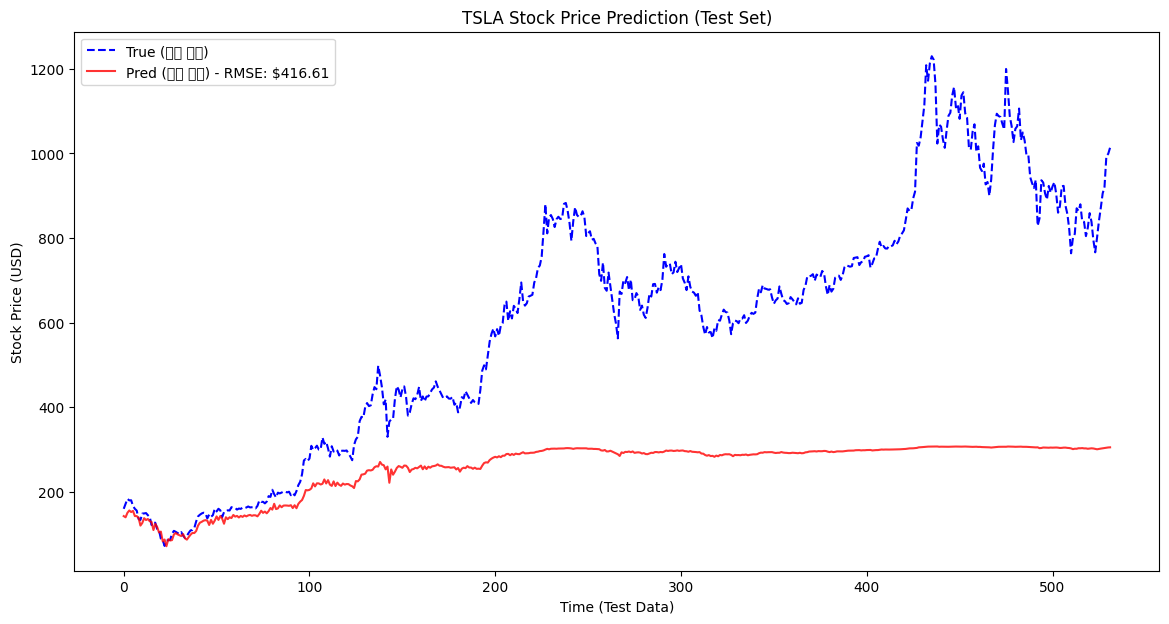

In [20]:
# -------------------------------------------------------------------
# 10. 시각화
# -------------------------------------------------------------------
plt.figure(figsize=(14, 7))
plt.title('TSLA Stock Price Prediction (Test Set)')
plt.plot(y_test_inv, label='True (실제 주가)', color='blue', linestyle='--')
plt.plot(pred_inv, label=f'Pred (예측 주가) - RMSE: ${rmse:,.2f}', color='red', alpha=0.8)
plt.legend()
plt.xlabel('Time (Test Data)')
plt.ylabel('Stock Price (USD)')
plt.show()